<a href="https://colab.research.google.com/github/larasatyr/DE-Komdigi/blob/main/UAS_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wholesale Customers Clustering
### K-Means vs DBSCAN

Notebook lengkap sesuai struktur akademik: Data Loading → Preprocessing → EDA → Helper Functions → Modeling → Evaluation → Interpretation.

## **1. Data Loading**
Unggah file CSV dataset (mis. `Wholesale customers data.csv`).

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
sns.set(style='whitegrid')

print('Silakan upload file CSV Anda:')
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print('File loaded:', filename)
display(df.head())

Silakan upload file CSV Anda:


Saving wholesale+customers.zip to wholesale+customers (1).zip
File loaded: wholesale+customers (1).zip


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## **2. Preprocessing**
Meliputi pengecekan missing, duplicates, validasi kolom, transformasi log, dan scaling.

In [9]:
# 2.1 – Missing & Duplicate
print('Shape:', df.shape)
print('\nMissing values per column:\n', df.isna().sum())
print('Duplicate rows:', df.duplicated().sum())

# 2.2 – Validate Features
expected = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f'Kolom berikut tidak ditemukan: {missing}. Periksa header CSV Anda.')
features = expected
X = df[features].copy()
display(X.head())

# 2.3 – Outlier (IQR)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (X < (Q1 - 1.5*IQR)) | (X > (Q3 + 1.5*IQR))
print('\nOutlier counts per feature:')
print(outlier_mask.sum())

# 2.4 – Transformasi & Scaling
X_log = np.log1p(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)
print('\nContoh data setelah log+scaling:')
display(pd.DataFrame(X_scaled, columns=features).head())

Shape: (440, 8)

Missing values per column:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
Duplicate rows: 0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185



Outlier counts per feature:
Fresh               20
Milk                28
Grocery             24
Frozen              43
Detergents_Paper    30
Delicassen          27
dtype: int64

Contoh data setelah log+scaling:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.486184,0.976299,0.440155,-1.509250,0.644143,0.408966
1,0.087889,0.990956,0.652171,0.134052,0.766043,0.627926
2,0.016356,0.891151,0.454687,0.376899,0.804405,1.776833
3,0.517477,-0.957973,-0.084792,1.141574,-0.328712,0.633133
4,0.880631,0.439662,0.395847,0.757322,0.404939,1.456588


## **3. Exploratory Data Analysis (EDA)**
Analisis visual lengkap distribusi, boxplot, korelasi, dan statistik.

In [10]:
# 3.1 – Descriptive Statistics
display(X.describe().T)
display(X_log.describe().T)

,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,8.732813,1.470618,1.386294,8.048378,9.048404,9.737123,11.627610
Milk,440.0,8.121615,1.080635,4.025352,7.335633,8.196435,8.880619,11.205027
Grocery,440.0,8.442205,1.111523,1.386294,7.675081,8.467267,9.273948,11.437997
Frozen,440.0,7.303128,1.281888,3.258097,6.611024,7.331043,8.176177,11.016496
Detergents_Paper,440.0,6.791781,1.709519,1.386294,5.551989,6.706242,8.274596,10.617123
Delicassen,440.0,6.671094,1.293960,1.386294,6.014321,6.873680,7.507278,10.777789


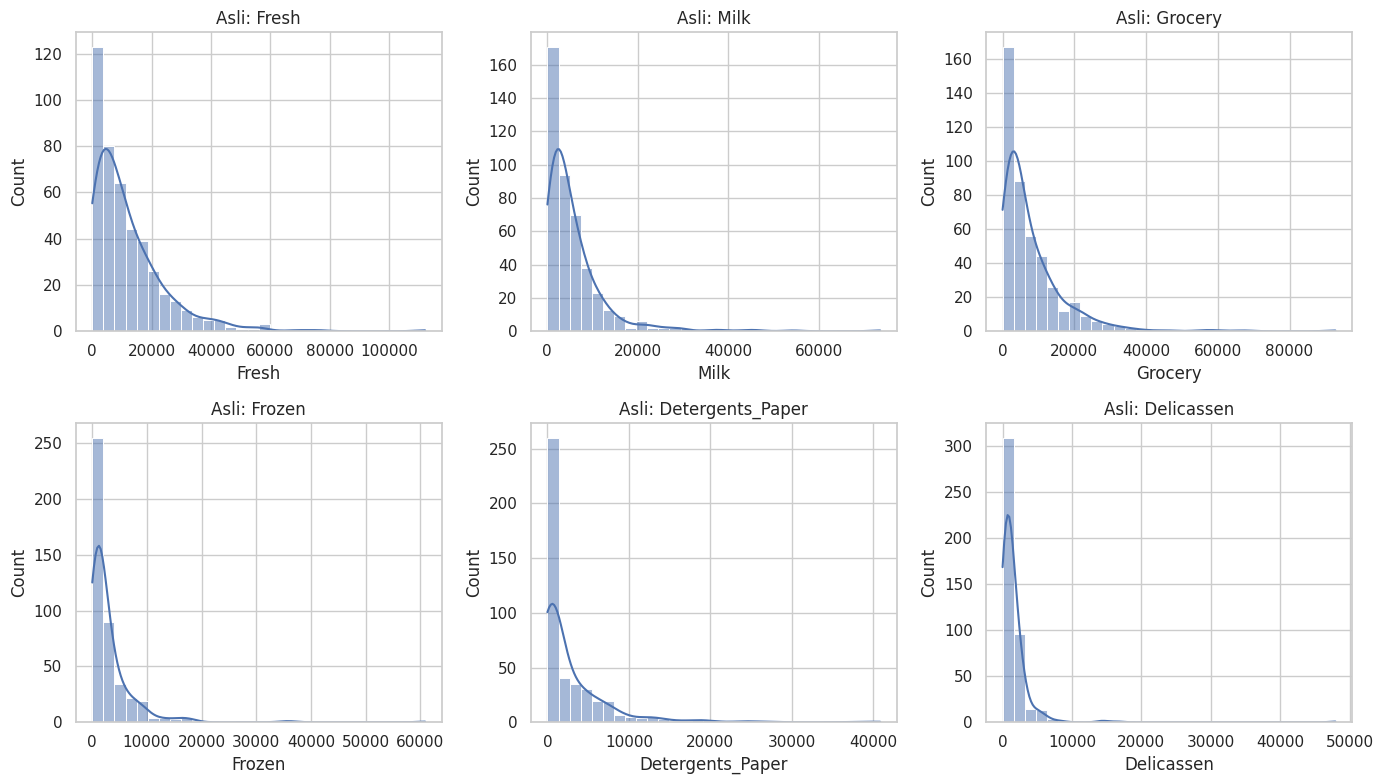

In [11]:
# 3.2 – Histogram Asli
plt.figure(figsize=(14,8))
for i,col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.histplot(X[col],kde=True,bins=30)
    plt.title(f'Asli: {col}')
plt.tight_layout(); plt.show()


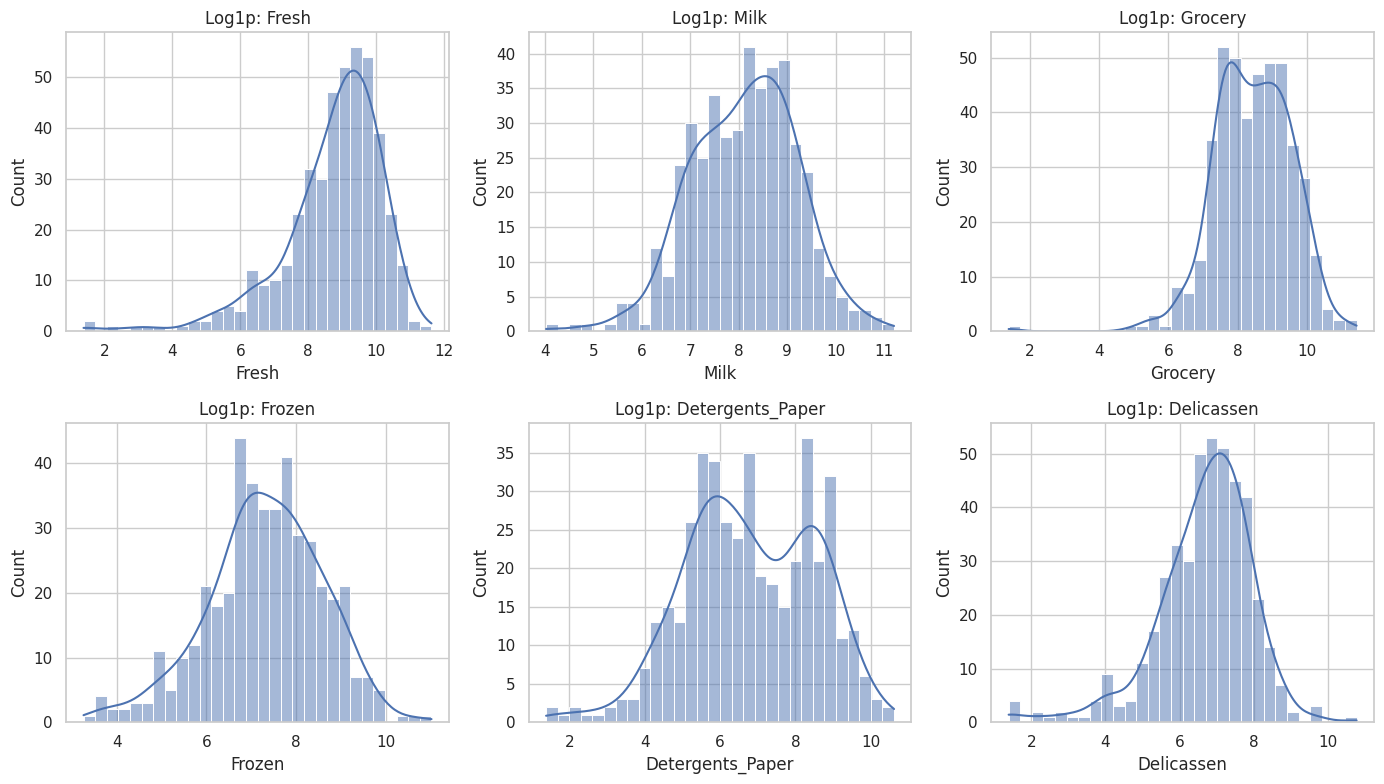

In [12]:
# 3.3 – Histogram Log
plt.figure(figsize=(14,8))
for i,col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.histplot(X_log[col],kde=True,bins=30)
    plt.title(f'Log1p: {col}')
plt.tight_layout(); plt.show()


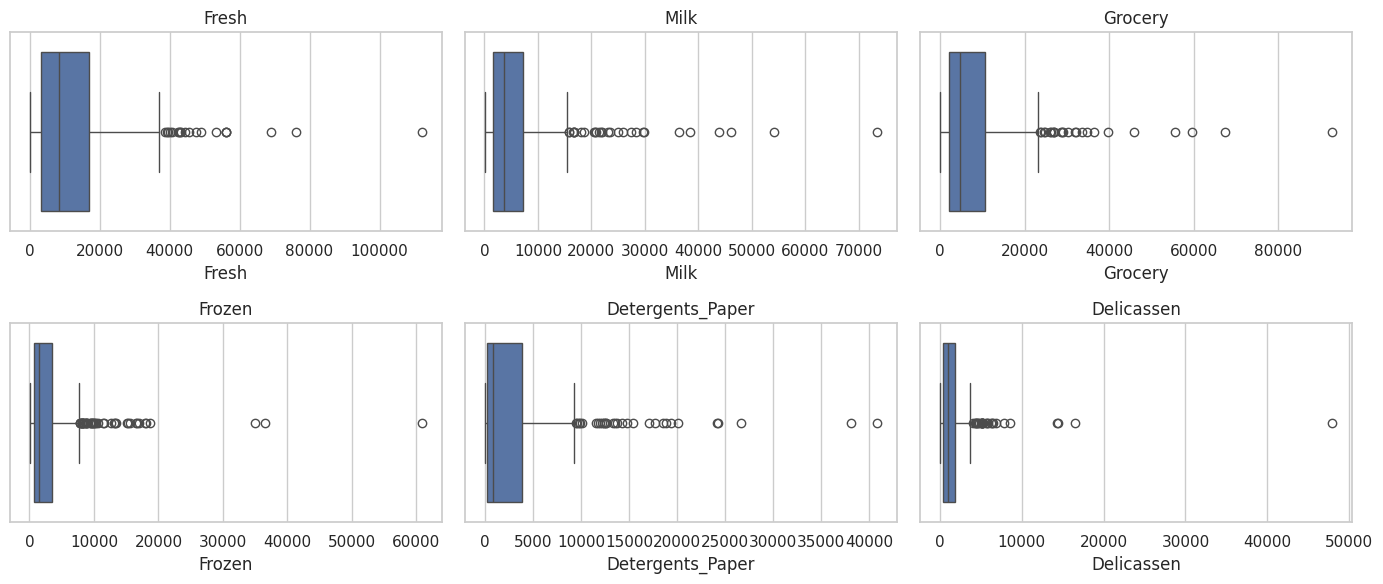

In [13]:
# 3.4 – Boxplots
plt.figure(figsize=(14,6))
for i,col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.boxplot(x=X[col])
    plt.title(col)
plt.tight_layout(); plt.show()

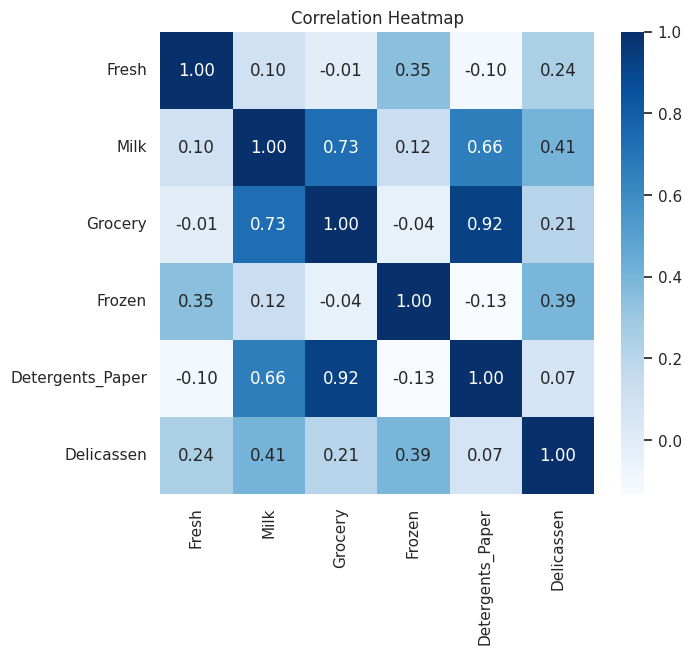

In [14]:
# 3.5 – Korelasi
plt.figure(figsize=(7,6))
sns.heatmap(X.corr(),annot=True,cmap='Blues',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## **4. Preparation for Modeling (Helper Functions)**

In [16]:
def safe_silhouette(X_arr, labels):
    labels = np.array(labels)
    mask = labels != -1
    if mask.sum() < 2:
        return np.nan
    try:
        return silhouette_score(X_arr[mask], labels[mask])
    except:
        return np.nan

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

def plot_pca(labels, title='PCA Plot'):
    labels = np.array(labels)
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
    plt.title(title)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()

## **5. Model Building — K-Means**

Best k: 2


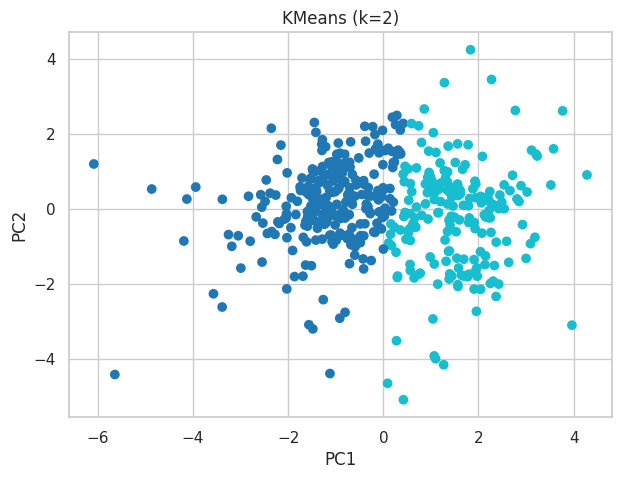

In [17]:
Ks = range(2,11)
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(safe_silhouette(X_scaled, labels))

best_k = Ks[int(np.nanargmax(sil_scores))]
print('Best k:', best_k)
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
kmeans_labels = kmeans.fit_predict(X_scaled)
plot_pca(kmeans_labels, f'KMeans (k={best_k})')

## **6. Model Building — DBSCAN**

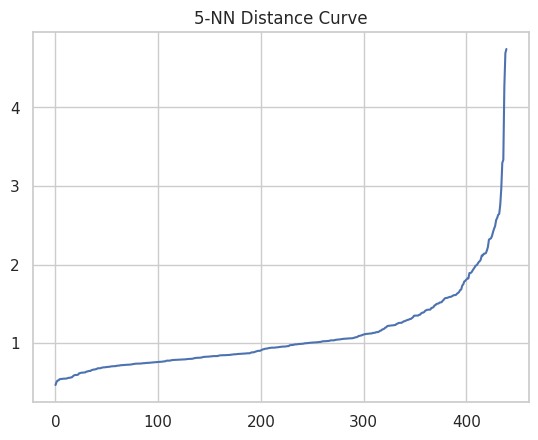

Best eps: 0.5499999999999999


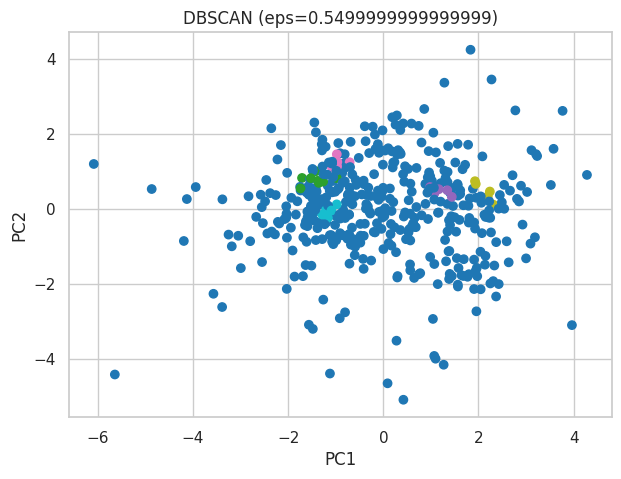

In [18]:
# 6.1 – k-NN Distance
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances,_ = nbrs.kneighbors(X_scaled)
dist_sorted = np.sort(distances[:,4])
plt.plot(dist_sorted); plt.title('5-NN Distance Curve'); plt.show()

# 6.2 – Grid Search
eps_list = np.linspace(0.3,1.0,15)
results = []
for eps in eps_list:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    sil = safe_silhouette(X_scaled, labels)
    results.append((eps,sil))

best_eps = max(results, key=lambda x: (x[1] if x[1] is not np.nan else -1))[0]
print('Best eps:', best_eps)
dbscan = DBSCAN(eps=best_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
plot_pca(dbscan_labels, f'DBSCAN (eps={best_eps})')

## **7. Evaluation & Comparison**

In [19]:
km_sil = safe_silhouette(X_scaled, kmeans_labels)
db_sil = safe_silhouette(X_scaled, dbscan_labels)
print('KMeans silhouette:', km_sil)
print('DBSCAN silhouette:', db_sil)
preferred = 'KMeans' if (km_sil >= db_sil or np.isnan(db_sil)) else 'DBSCAN'
print('Preferred method:', preferred)

KMeans silhouette: 0.2903284869973543
DBSCAN silhouette: 0.4768570034307461
Preferred method: DBSCAN


## **8. Interpretation & Final Profiling**

In [21]:
# KMeans centers
centers_scaled = kmeans.cluster_centers_
centers_log = scaler.inverse_transform(centers_scaled)
centers_original = np.expm1(centers_log)
centers_df = pd.DataFrame(centers_original, columns=features)
print('KMeans Centers (Original Scale):')
display(centers_df)

# DBSCAN profiling
df_db = df.copy()
df_db['Cluster_DBSCAN'] = dbscan_labels
valid_clusters = [c for c in set(dbscan_labels) if c != -1]
if valid_clusters:
    profile_db = df_db[df_db['Cluster_DBSCAN']!=-1].groupby('Cluster_DBSCAN')[features].mean()
    print('DBSCAN Cluster Profiles:')
    display(profile_db)
else:
    print('DBSCAN did not form valid clusters.')

KMeans Centers (Original Scale):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,8580.591769,1753.697507,2274.383823,2063.830219,287.370418,649.350279
1,4013.880833,8061.572603,12051.066066,953.532640,4035.601840,1022.085648


DBSCAN Cluster Profiles:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster_DBSCAN,,,,,,
0,18734.625000,1436.375000,2095.125000,2371.875000,203.750000,1202.000000
1,7685.714286,6880.857143,8916.714286,1471.714286,3148.714286,2164.285714
2,15356.600000,2256.200000,2730.400000,7219.200000,381.600000,1204.000000
3,6754.000000,12055.200000,18613.400000,2006.800000,7684.200000,1565.200000
4,6403.400000,2219.600000,1694.200000,1691.600000,292.000000,628.400000
